In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
import tifffile
from keras.initializers import he_normal

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
def unet_model(input_shape):
    init = he_normal()
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=init)(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=init)(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=init)(pool2)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4_a = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=init)(pool3)
    conv4_a = BatchNormalization()(conv4_a)
    pool4_a = MaxPooling2D((2, 2))(conv4_a)

    
    # Decoder
    up4_a = UpSampling2D((2, 2))(pool4_a)
    merge4_a = concatenate([conv4_a, up4_a], axis=-1)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=init)(merge4_a)
    conv4 = BatchNormalization()(conv4)
    
    up4 = UpSampling2D((2, 2))(pool3)
    merge4 = concatenate([conv3, up4], axis=-1)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=init)(merge4)
    conv4 = BatchNormalization()(conv4)
    
    up5 = UpSampling2D((2, 2))(conv4)
    merge5 = concatenate([conv2, up5], axis=-1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=init)(merge5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = concatenate([conv1, up6], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=init)(merge6)
    conv6 = BatchNormalization()(conv6)
    
    # Output
    outputs = Conv2D(1, (1, 1))(conv6)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

input_shape = (768, 768, 1)  # Height x Width x Channels
with strategy.scope():
    model = unet_model(input_shape)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


/home/gh464/miniconda3/envs/tensorflow2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 768, 768, 1)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 768, 768, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 768, 768, 64)         256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 384, 384, 64)         0         ['batch_normalization_8[

In [2]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class DisplayPrediction(Callback):
    def __init__(self, test_image_path, ground_truth_path, img_size = (768,768)):
        self.test_image_path = test_image_path
        self.ground_truth_path = ground_truth_path
        self.img_size = img_size

    def on_epoch_end(self, epoch, logs=None):
        img_y = np.array(Image.open(self.ground_truth_path).convert('L')).astype(np.float32)
        img_y = img_y/img_y.max()
        
        img_x = tifffile.imread(self.test_image_path)
        img_x = img_x/img_x.max()

        target_shape = self.img_size
            
        dx = max(0, img_x.shape[0] - target_shape[0])
        dy = max(0, img_x.shape[1] - target_shape[1])
        
        x_start = dx // 2
        x_end = x_start + target_shape[0]
        y_start = dy // 2
        y_end = y_start + target_shape[1]
        
        img_x = img_x[x_start:x_end, y_start:y_end]
    
        pad_x0, pad_x1 = max(0, target_shape[0] - img_x.shape[0]), max(0, target_shape[1] - img_x.shape[1])
        pad_x = ((pad_x0 // 2, pad_x0 - pad_x0 // 2), (pad_x1 // 2, pad_x1 - pad_x1 // 2))
        img_x = np.pad(img_x, pad_x, mode='constant')

        target_shape = self.img_size
        
        dx = max(0, img_y.shape[0] - target_shape[0])
        dy = max(0, img_y.shape[1] - target_shape[1])
        
        x_start = dx // 2
        x_end = x_start + target_shape[0]
        y_start = dy // 2
        y_end = y_start + target_shape[1]
        
        img_y = img_y[x_start:x_end, y_start:y_end]
        
        pad_y0, pad_y1 = max(0, target_shape[0] - img_y.shape[0]), max(0, target_shape[1] - img_y.shape[1])
        pad_y = ((pad_y0 // 2, pad_y0 - pad_y0 // 2), (pad_y1 // 2, pad_y1 - pad_y1 // 2))
        img_y = np.pad(img_y, pad_x, mode='constant')
        # Model prediction
        pred = self.model.predict(img_x[np.newaxis, :, :, np.newaxis])[0, :, :, 0]

        # Display images
        plt.figure(figsize=(10, 10))

        plt.subplot(1, 3, 1)
        plt.title('Input')
        plt.imshow(img_x, cmap='jet')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.imshow(img_y, cmap='jet')

        plt.subplot(1, 3, 3)
        plt.title('Prediction')
        plt.imshow(pred, cmap='jet', vmin = img_y.min(), vmax = img_y.max())

        plt.show()


Epoch 1/150


2023-11-08 15:35:25.973240: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-11-08 15:35:26.824163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2023-11-08 15:35:26.887606: I t

1/1 [==============================] - 0s 339ms/step - loss: 0.0104 - accuracy: 0.89


2023-11-08 15:39:19.863140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


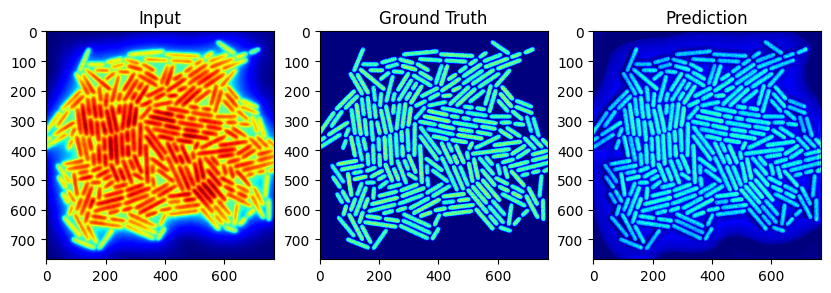

1738/1738 [==============================] - 234s 130ms/step - loss: 0.0104 - accuracy: 0.8955
Epoch 2/150
1/1 [==============================] - 0s 32ms/steps - loss: 0.0032 - accuracy: 0.89


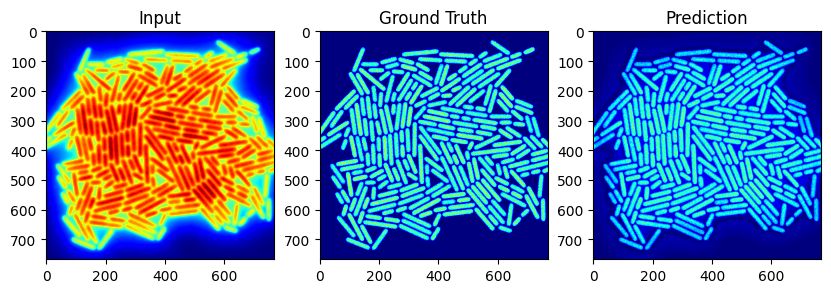

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0032 - accuracy: 0.8964
Epoch 3/150
1/1 [==============================] - 0s 30ms/steps - loss: 0.0030 - accuracy: 0.89


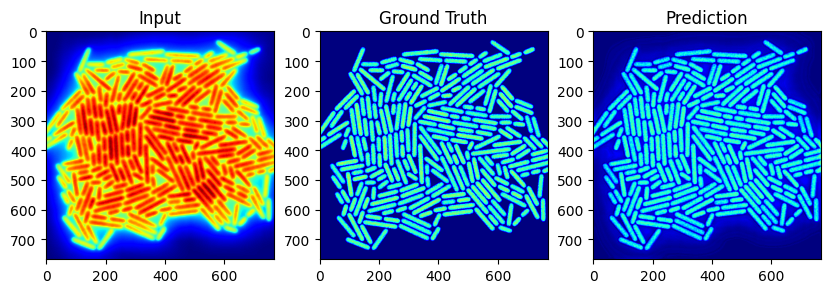

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0030 - accuracy: 0.8964
Epoch 4/150
1/1 [==============================] - 0s 34ms/steps - loss: 0.0030 - accuracy: 0.89


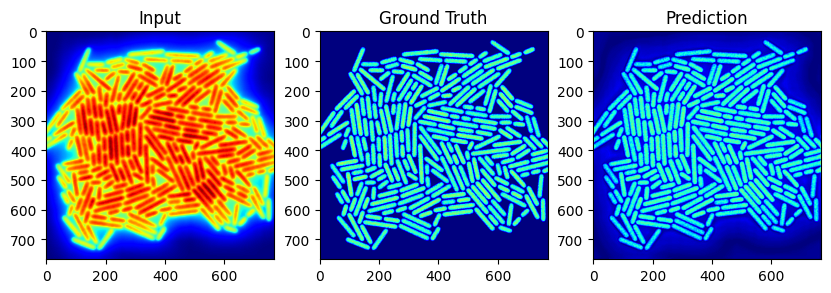

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0030 - accuracy: 0.8964
Epoch 5/150
1/1 [==============================] - 0s 29ms/steps - loss: 0.0030 - accuracy: 0.89


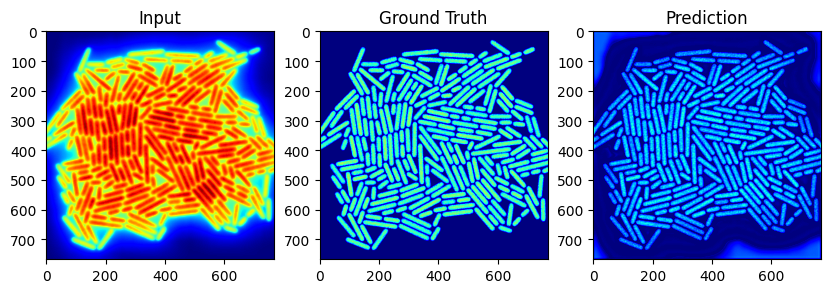

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0030 - accuracy: 0.8963
Epoch 6/150
1/1 [==============================] - 0s 29ms/steps - loss: 0.0028 - accuracy: 0.89


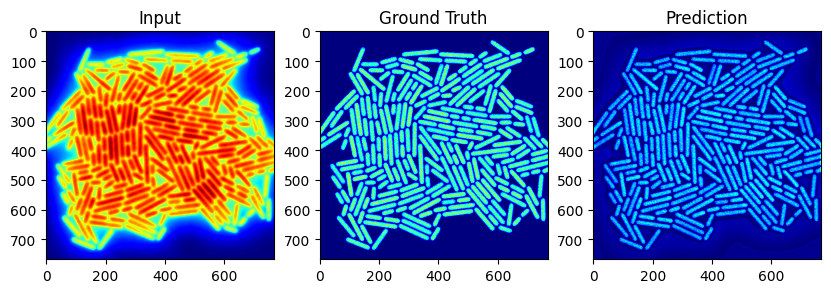

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0028 - accuracy: 0.8964
Epoch 7/150
1/1 [==============================] - 0s 72ms/steps - loss: 0.0028 - accuracy: 0.89


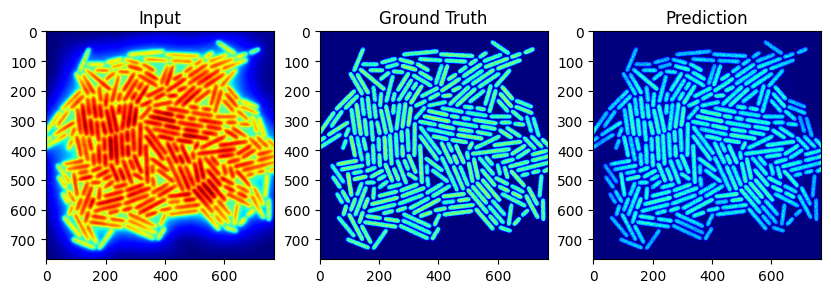

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0028 - accuracy: 0.8964
Epoch 8/150
1/1 [==============================] - 0s 33ms/steps - loss: 0.0027 - accuracy: 0.89


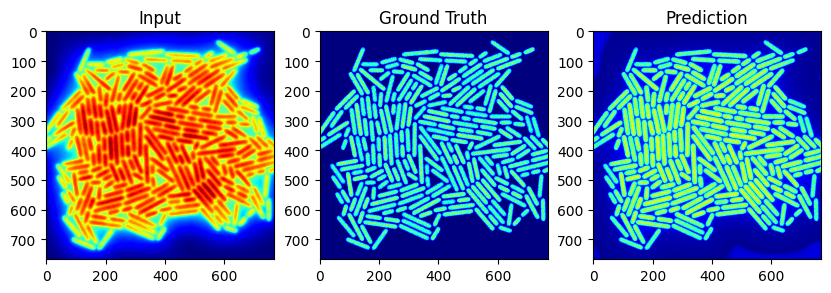

1738/1738 [==============================] - 225s 130ms/step - loss: 0.0027 - accuracy: 0.8964
Epoch 9/150
1/1 [==============================] - 0s 28ms/steps - loss: 0.0027 - accuracy: 0.89


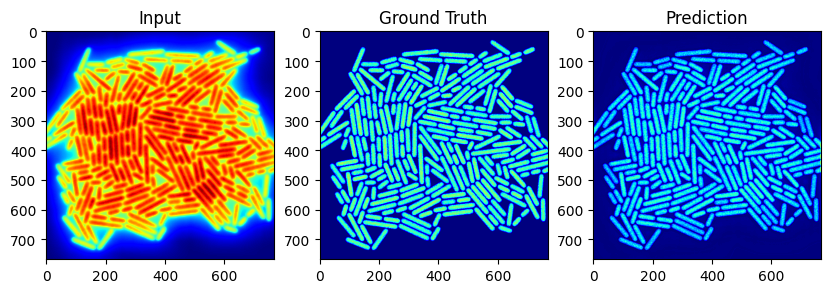

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0027 - accuracy: 0.8964
Epoch 10/150
1/1 [==============================] - 0s 29ms/steps - loss: 0.0027 - accuracy: 0.89


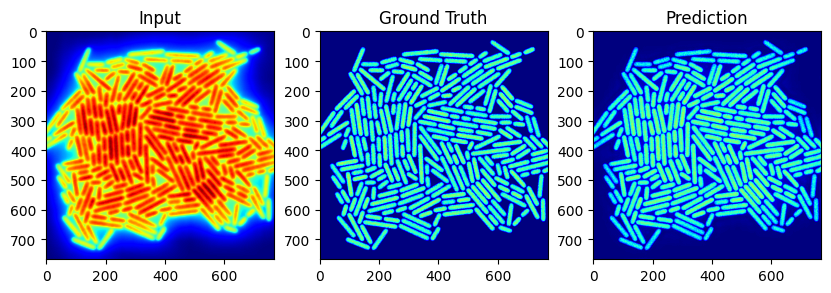

1738/1738 [==============================] - 225s 130ms/step - loss: 0.0027 - accuracy: 0.8964
Epoch 11/150
1/1 [==============================] - 0s 30ms/steps - loss: 0.0026 - accuracy: 0.89


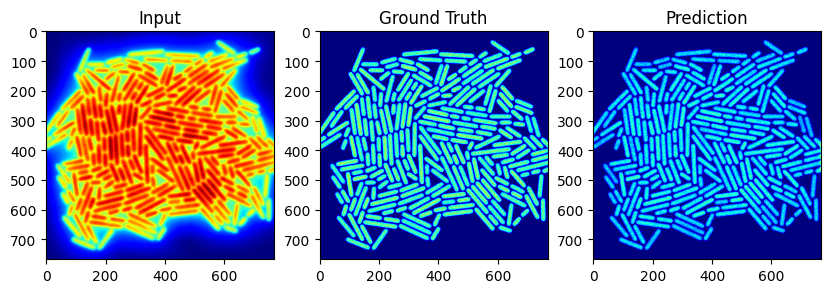

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0026 - accuracy: 0.8964
Epoch 12/150
1/1 [==============================] - 0s 63ms/steps - loss: 0.0026 - accuracy: 0.89


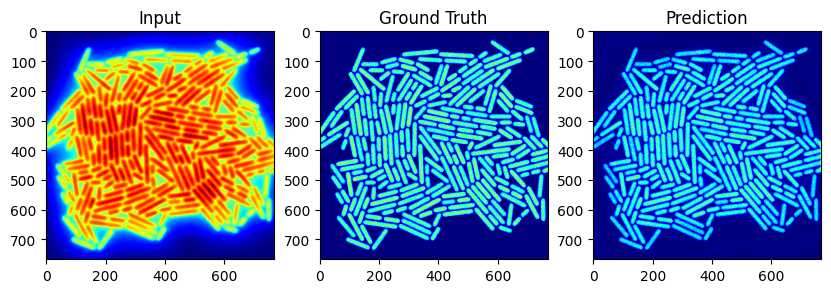

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0026 - accuracy: 0.8964
Epoch 13/150
1/1 [==============================] - 0s 30ms/steps - loss: 0.0026 - accuracy: 0.89


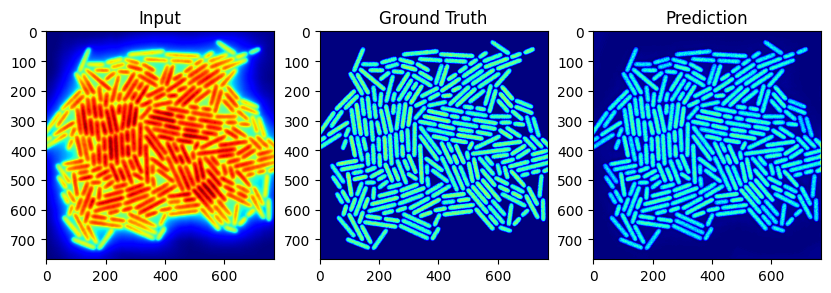

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0026 - accuracy: 0.8964
Epoch 14/150
1/1 [==============================] - 0s 30ms/steps - loss: 0.0025 - accuracy: 0.89


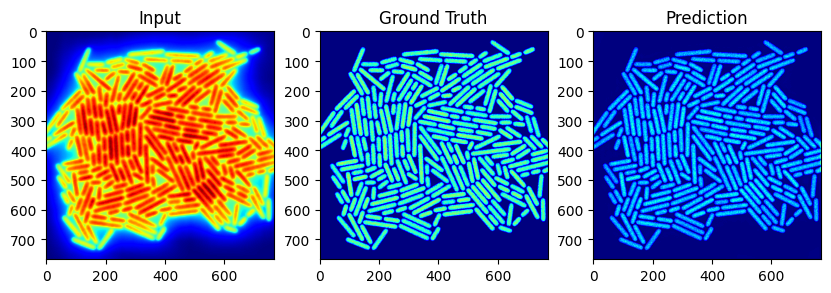

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 15/150
1/1 [==============================] - 0s 29ms/steps - loss: 0.0025 - accuracy: 0.89


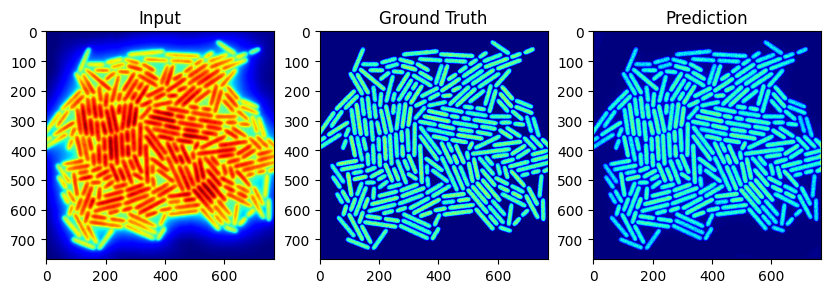

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 16/150
1/1 [==============================] - 0s 30ms/steps - loss: 0.0025 - accuracy: 0.89


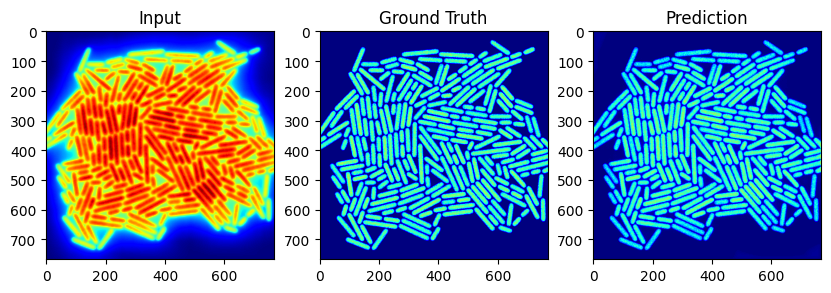

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 17/150
1/1 [==============================] - 0s 29ms/steps - loss: 0.0025 - accuracy: 0.89


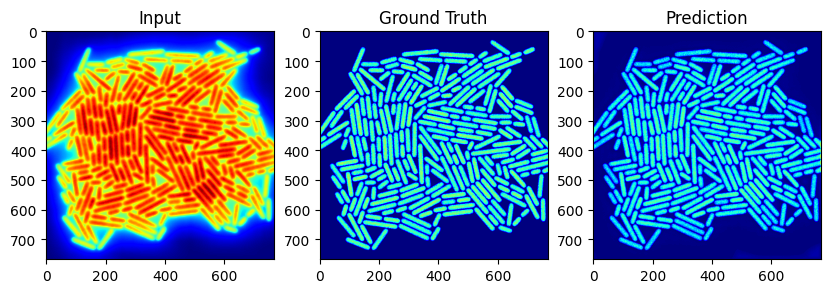

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 18/150
1/1 [==============================] - 0s 50ms/steps - loss: 0.0025 - accuracy: 0.89


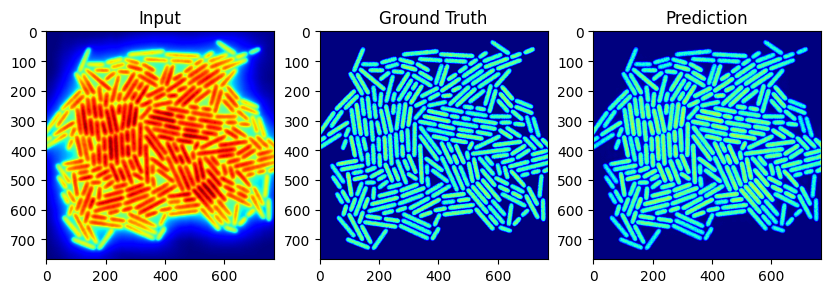

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 19/150
1/1 [==============================] - 0s 30ms/steps - loss: 0.0025 - accuracy: 0.89


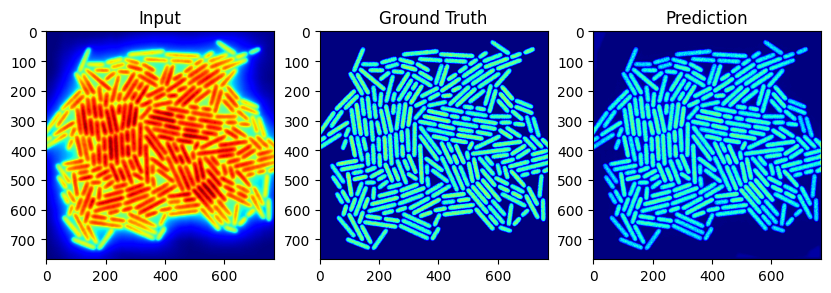

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 20/150
1/1 [==============================] - 0s 33ms/steps - loss: 0.0025 - accuracy: 0.89


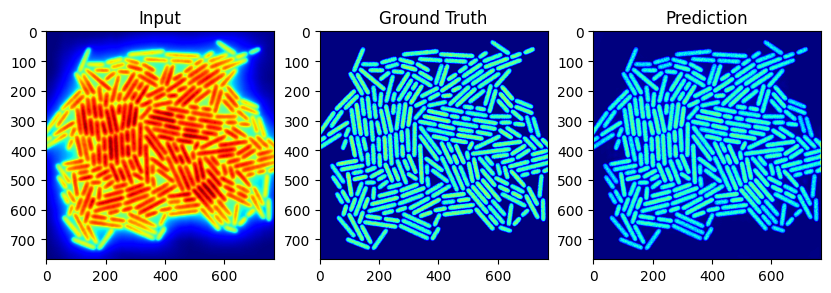

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0025 - accuracy: 0.8964
Epoch 21/150
1/1 [==============================] - 0s 29ms/steps - loss: 0.0024 - accuracy: 0.89


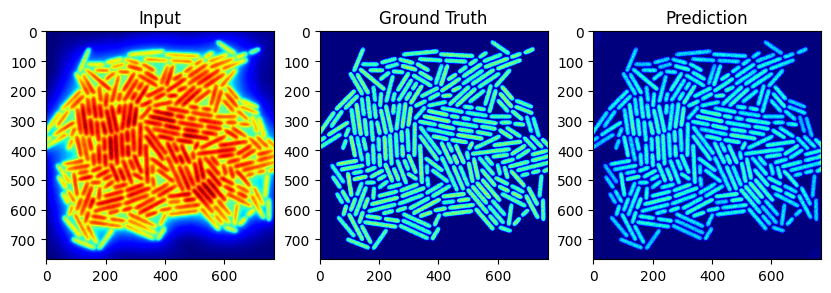

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0024 - accuracy: 0.8964
Epoch 22/150
1/1 [==============================] - 0s 28ms/steps - loss: 0.0024 - accuracy: 0.89


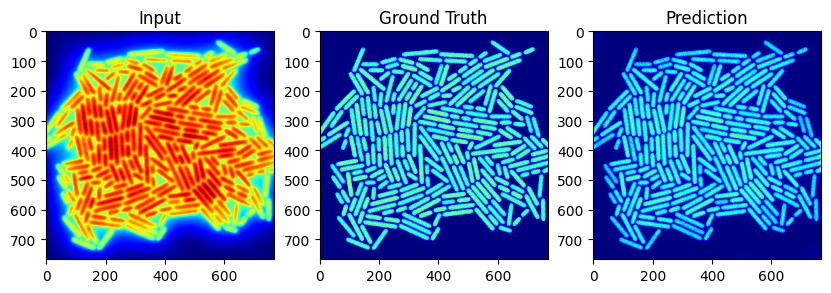

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0024 - accuracy: 0.8964
Epoch 23/150
1/1 [==============================] - 0s 32ms/steps - loss: 0.0024 - accuracy: 0.89


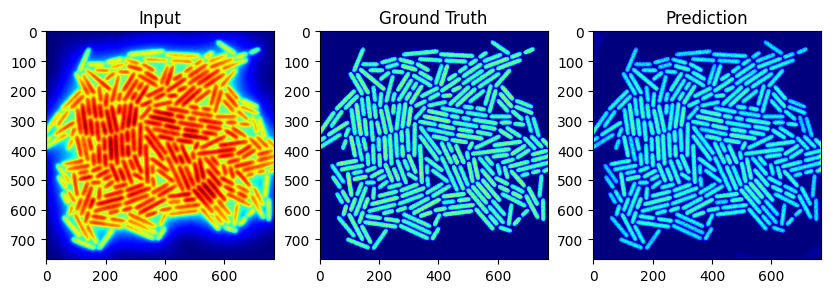

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0024 - accuracy: 0.8964
Epoch 24/150
1/1 [==============================] - 0s 31ms/steps - loss: 0.0024 - accuracy: 0.89


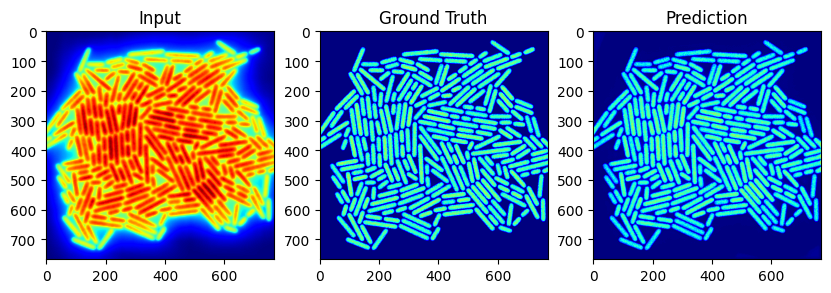

1738/1738 [==============================] - 226s 130ms/step - loss: 0.0024 - accuracy: 0.8964
Epoch 25/150
 408/1738 [======>.......................] - ETA: 2:52 - loss: 0.0023 - accuracy: 0.9031

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from PIL import Image

class PaddedDataGenerator(Sequence):
    def __init__(self, dir_x, dir_y, batch_size=128, img_size=(768, 768)):
        self.filenames_x = sorted(os.listdir(dir_x))
        self.filenames_y = sorted(os.listdir(dir_y))
        self.dir_x = dir_x
        self.dir_y = dir_y
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.filenames_x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames_x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.filenames_y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x_padded = np.zeros((len(batch_x), *self.img_size, 1))
        batch_y_padded = np.zeros((len(batch_y), *self.img_size, 1))

        for i, fname in enumerate(batch_x):
            img_path = os.path.join(self.dir_x, fname)
            img_x = tifffile.imread(img_path)
            img_x = img_x/img_x.max()
            
            target_shape = self.img_size
            
            dx = max(0, img_x.shape[0] - target_shape[0])
            dy = max(0, img_x.shape[1] - target_shape[1])
            
            x_start = dx // 2
            x_end = x_start + target_shape[0]
            y_start = dy // 2
            y_end = y_start + target_shape[1]
            
            img_x = img_x[x_start:x_end, y_start:y_end]
        
            pad_x0, pad_x1 = max(0, target_shape[0] - img_x.shape[0]), max(0, target_shape[1] - img_x.shape[1])
            pad_x = ((pad_x0 // 2, pad_x0 - pad_x0 // 2), (pad_x1 // 2, pad_x1 - pad_x1 // 2))
            batch_x_padded[i, :, :, 0] = np.pad(img_x, pad_x, mode='constant')
        
        for i, fname in enumerate(batch_y):
            img_path = os.path.join(self.dir_y, fname)
            img_y = np.array(Image.open(img_path).convert('L')).astype(np.float32)
            img_y = img_y/img_y.max()
            
            target_shape = self.img_size
            
            dx = max(0, img_y.shape[0] - target_shape[0])
            dy = max(0, img_y.shape[1] - target_shape[1])
            
            x_start = dx // 2
            x_end = x_start + target_shape[0]
            y_start = dy // 2
            y_end = y_start + target_shape[1]
            
            img_y = img_y[x_start:x_end, y_start:y_end]
            
            pad_y0, pad_y1 = max(0, target_shape[0] - img_y.shape[0]), max(0, target_shape[1] - img_y.shape[1])
            pad_y = ((pad_y0 // 2, pad_y0 - pad_y0 // 2), (pad_y1 // 2, pad_y1 - pad_y1 // 2))
            batch_y_padded[i, :, :, 0] = np.pad(img_y, pad_y, mode='constant')


        return batch_x_padded, batch_y_padded

display_cbk = DisplayPrediction('../microcolony_analysis/simulated_colonies_empirical_PSF_corrected/training_data_100x_0.55_green_1.49_1.518/synth_imgs/0853.tif', "../microcolony_analysis/data/fluorescent_scenes/00854.png")
train_gen = PaddedDataGenerator('../microcolony_analysis/simulated_colonies_empirical_PSF_corrected/training_data_100x_0.55_green_1.49_1.518/synth_imgs/', '../microcolony_analysis/data/fluorescent_scenes/', batch_size=2)
model.fit(train_gen, steps_per_epoch=len(train_gen), epochs=150, callbacks=[display_cbk])


In [ ]:
import numpy as np
ground_truth_path = "../microcolony_analysis/data/fluorescent_scenes/03276.png"
test_image_path = '../microcolony_analysis/simulated_colonies_empirical_PSF_corrected/training_data_100x_0.55_green_1.49_1.518/synth_imgs/3275.tif'
img_y = np.array(Image.open(ground_truth_path).convert('L')).astype(np.float32)
img_y = img_y/img_y.max()

img_x = tifffile.imread(test_image_path)
img_x = img_x/img_x.max()
img_size = (256, 256)

# For img_x
crop_x0 = (img_x.shape[0] - img_size[0]) // 2
crop_x1 = crop_x0 + img_size[0]
crop_y0 = (img_x.shape[1] - img_size[1]) // 2
crop_y1 = crop_y0 + img_size[1]
img_x = img_x[crop_x0:crop_x1, crop_y0:crop_y1]

# For img_y
crop_x0 = (img_y.shape[0] - img_size[0]) // 2
crop_x1 = crop_x0 + img_size[0]
crop_y0 = (img_y.shape[1] - img_size[1]) // 2
crop_y1 = crop_y0 + img_size[1]
img_y = img_y[crop_x0:crop_x1, crop_y0:crop_y1]
# Model prediction
pred = model.predict(img_x[np.newaxis, :, :, np.newaxis])[0, :, :, 0]

# Display images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title('Input')
plt.imshow(img_x, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(img_y, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Prediction')
plt.imshow(pred, cmap='gray')

plt.show()

In [ ]:
ground_truth_path = "../microcolony_analysis/data_uniform/fluorescent_scenes/00500.png"
test_image_path = '../microcolony_analysis/simulated_colonies_empirical_PSF_corrected/training_data_100x_0.55_green_1.49_1.518/synth_imgs/0499.tif'
img_y = np.array(Image.open(ground_truth_path).convert('L')).astype(np.float32)
img_y = img_y/img_y.max()

img_x = tifffile.imread(test_image_path)
img_x = img_x/img_x.max()
img_size = (256, 256)

# For img_x
crop_x0 = (img_x.shape[0] - img_size[0]) // 2
crop_x1 = crop_x0 + img_size[0]
crop_y0 = (img_x.shape[1] - img_size[1]) // 2
crop_y1 = crop_y0 + img_size[1]
img_x = img_x[crop_x0:crop_x1, crop_y0:crop_y1]

# For img_y
crop_x0 = (img_y.shape[0] - img_size[0]) // 2
crop_x1 = crop_x0 + img_size[0]
crop_y0 = (img_y.shape[1] - img_size[1]) // 2
crop_y1 = crop_y0 + img_size[1]
img_y = img_y[crop_x0:crop_x1, crop_y0:crop_y1]
# Model prediction
pred = model.predict(img_x[np.newaxis, :, :, np.newaxis])[0, :, :, 0]

# Display images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title('Input')
plt.imshow(img_x, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(img_y, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Prediction')
plt.imshow(pred, cmap='gray')

plt.show()